# **Imports**
First of all, we import all the libraries and functions that we will use throughout the notebook.

In [1]:
import os
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow

from tensorflow import keras 
from keras import models
from keras import applications
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
from keras.models import *
from keras import backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# **Data loading**

In [2]:
train = np.genfromtxt('data/train.csv', delimiter = ',', skip_header = 1)

X = np.array(train[:, 1:])
Y = np.array(train[:, 0])
n = X.shape[0]
m = X.shape[1]

print("Number of training samples: ", n)
print ("Number of features: ", m)

Number of training samples:  42000
Number of features:  784


# **Data preprocessing**

In order to train a neural network we perform the following normalizations and transformations:

* Resize the images to $64×64$.
* Normalize the training data dividing by $255$.

In [3]:
X = np.reshape(X, (X.shape[0], 28, 28, 1))
X = X / 255.0
print (X.shape)

(42000, 28, 28, 1)


# **Data display**

Let's see some randomly selected images from the dataset.

                                                                   Random examples                                                                    


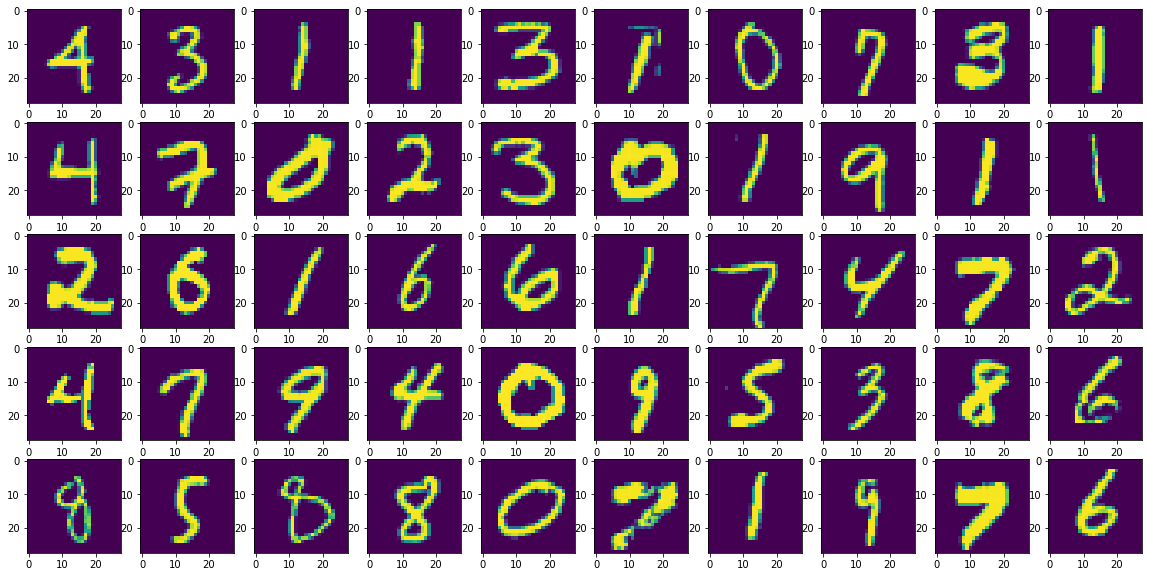

In [4]:
index = np.random.randint(0, n, 50)
plt.figure(figsize = (20, 10))
for i, idx in enumerate(index):
    plt.subplot(5, 10, i+1)
    plt.imshow(X[idx])
print("Random examples".center(150))   
plt.show()

We show the number of examples of each label. As you can see the training data is balanced.

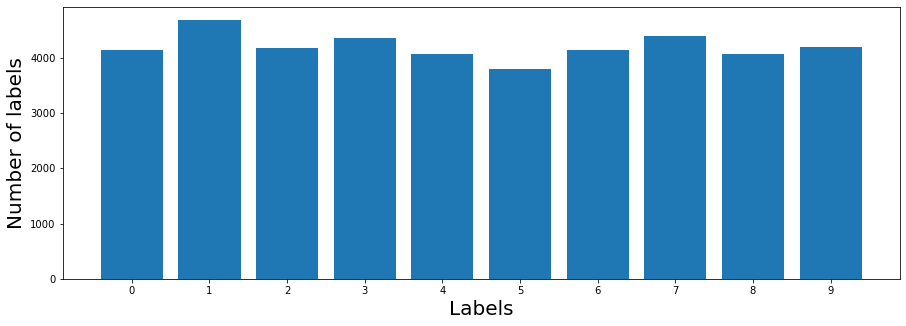

In [5]:
x_labels = sorted(list(set(Y)))
y_labels = [Y.tolist().count(i) for i in x_labels]

plt.figure(figsize = (15,5))
plt.ylabel('Number of labels',  fontsize=20)
plt.xlabel('Labels',  fontsize=20)
plt.xticks([i for i in range(len(x_labels))]) 
plt.bar(x_labels, y_labels)
plt.show()

# **Division of data into train and test**

Since we are facing a classification problem with multiple classes, we will transform the output $Y$ class following a one-hot encoding.

In [6]:
Y = to_categorical(Y)

Let's show some random example to check that everything is correct.

Output associated to the label:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


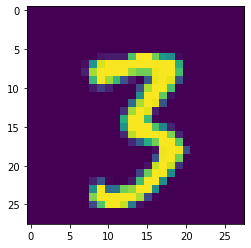

In [7]:
sample = np.random.choice(n)
plt.imshow(X[sample])
print("Output associated to the label: ", Y[sample])

# **Model training**

In [8]:
inputs = Input(shape = (28, 28, 1))
model = Conv2D(16, kernel_size  = (3, 3), activation = 'relu')(inputs)
model = Conv2D(32, kernel_size  = (3, 3), activation = 'relu')(model)
model = MaxPooling2D(pool_size  = (2, 2))(model)
model = Conv2D(64, kernel_size = (3, 3), activation = 'relu')(model)
model = Conv2D(128, kernel_size = (3, 3), activation = 'relu')(model)
model = MaxPooling2D(pool_size  = (2, 2))(model)
model = Dropout(0.25)(model)
model = Flatten()(model)

model = Dense(256, activation = 'relu')(model)
model = Dropout(0.25)(model)
model = Dense(10, activation   = 'softmax')(model)

To mitigate overtraining we apply early stopping.

In [9]:
model = Model(inputs = inputs, outputs = model)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=20,verbose=1)
]

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 128)         0     

# **Entrenamiento del modelo**

We will split the train set into two new sets $p$ and $v$ . Basically, we will use the train set $p$ to train the model and the validation set $v$ to estimate the hyperparameters (number of iterations, etc). The train set was divided into $80\%$ for p and $20\%$ for $v$.

In [10]:
indexs = np.arange(X.shape[0])
posicion = int(X.shape[0] * 0.8)

X_train_p = X[indexs[:posicion]]
X_train_v = X[indexs[posicion:]] 

Y_train_p = Y[indexs[:posicion]]
Y_train_v = Y[indexs[posicion:]]

print(X_train_v.shape)
print("Number of examples of X_train_p: ", X_train_p.shape[0])
print("Number of examples of X_train_v: ", X_train_v.shape[0])

(8400, 28, 28, 1)
Number of examples of X_train_p:  33600
Number of examples of X_train_v:  8400


We start the training of the network. We specify the training sets and the number of iterations. We will save all the information in the history variable $h$ so that later we can plot the obtained result.

In [11]:
h = model.fit(X_train_p, Y_train_p, batch_size = 128, epochs = 500, validation_data = (X_train_v, Y_train_v),  callbacks=callbacks_list)

Epoch 1/500
263/263 [==============================] - 322s 1s/step - loss: 0.6128 - accuracy: 0.8055 - val_loss: 0.0530 - val_accuracy: 0.9827

Epoch 00001: val_loss improved from inf to 0.05304, saving model to model.h5
Epoch 2/500
199/263 [=====================>........] - ETA: 50s - loss: 0.0642 - accuracy: 0.9796

We show the history of the behavior for the cost function in the training and validation sets.

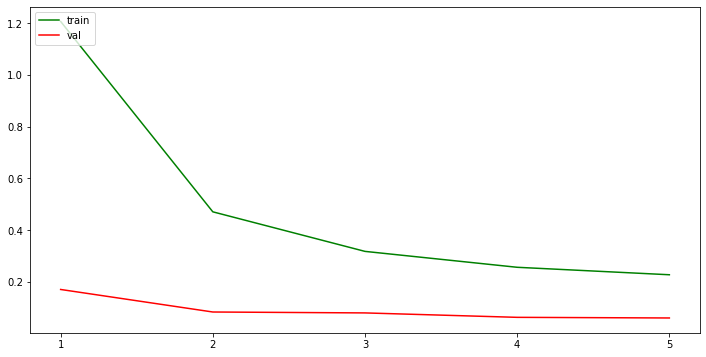

In [ ]:
plt.figure(figsize = (12,6))

Iterations = len(h.history['val_loss']) + 1

plt.plot(range(1, Iterations), h.history['loss'], 'g', label = 'train')
plt.plot(range(1, Iterations), h.history['val_loss'], 'r', label = 'validation')
plt.legend(['train', 'val'], loc ='upper left')
plt.xticks([i for i in range(1, Iterations)]) 
plt.show()

In [ ]:
for i in range (sample.shape[0]):
    x = np.reshape(np.array(test.iloc[i, :]), ((28, 28, 1)))
    x = np.array([x / 255])
    sample.iloc[i,1] = model.predict(x).argmax(axis = 1)

In [ ]:
sample.to_csv('./submission.csv',index=False)